## Import

In [1]:
from yasai_funcs import yasai
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import optim
from PIL import Image
import torch.nn.functional as F
import cv2
# from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# ### for_multi_GPU
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# print(torch.cuda.device_count())
# print(torch.cuda.is_available())

## Root

In [3]:
ROOT_PATH = '/home/yasaisen/Desktop/09_research/09_research_main/lab_12'

In [4]:
DATA_PATH = '/home/yasaisen/Desktop/09_research/09_research_main/lab_03'

dataset_folder = 'dataset_C_v_2.9.3'

train_for_base_img_path = os.path.join(DATA_PATH, dataset_folder, 'train_for_base_imgs_rgb')
train_for_step_img_path = os.path.join(DATA_PATH, dataset_folder, 'train_for_step_imgs_rgb')

valid_img_path = os.path.join(DATA_PATH, dataset_folder, 'valid_imgs_rgb')
test_img_path = os.path.join(DATA_PATH, dataset_folder, 'test_imgs_rgb')

## Aug

In [5]:
img_size = 224
train_bsz = 64
device = 'cuda'
epochs = 30
valid_bsz = 8
test_bsz = 8
CLASSES = ['NORMAL', 'RLN', 'RSLN']

## Dataset

In [6]:
def get_df(img_paths):
    images, labels = [], []

    i = 0
    for img_path in img_paths:
        for get_img_name in os.listdir(img_path):
            images += [os.path.join(img_path, get_img_name)]
            labels += [get_img_name.split('_')[0]]
            
            i = i+1

    PathDF = pd.DataFrame({'images': images, 'labels': labels})
    print(i)
    PathDF.head()
    return PathDF

In [7]:
train_df = get_df([train_for_base_img_path, train_for_step_img_path])
test_df = get_df([valid_img_path, test_img_path])

9000
1954


In [8]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.groupby('labels').agg('size')

labels
NORMAL    3000
RLN       3000
RSLN      3000
dtype: int64

In [9]:
transform = transforms.Compose([
            transforms.ToTensor()
            ])

In [10]:
class mod_Dataset(Dataset):
    def __init__(self, path_df, model, transform=None):
        self.path_df = path_df
        self.transform = transform
        self.model = model

    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        if self.transform is not None:
            trans_Resize = transforms.Resize(224)
            trans_ToTensor = transforms.ToTensor()

            images = trans_Resize(Image.open(self.path_df.iloc[idx]['images']).convert('RGB'))
            images = trans_ToTensor(images)

            images = yasai.bounding_crop(images, self.model)
            images = images.astype(np.uint8)
            images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
            images = Image.fromarray(images)
            images = self.transform(images)

            if self.path_df.iloc[idx]['labels'] == CLASSES[0]:
                lables = torch.tensor([1, 0, 0], dtype=torch.float32)
            if self.path_df.iloc[idx]['labels'] == CLASSES[1]:
                lables = torch.tensor([0, 1, 0], dtype=torch.float32)
            if self.path_df.iloc[idx]['labels'] == CLASSES[2]:
                lables = torch.tensor([0, 0, 1], dtype=torch.float32)

        return images, lables

In [11]:
trained_unet_model = yasai.model_load_v1('./../lab_10/model_bast_ima_2305151053.pt').cuda()

Successfully loaded from ./../lab_10/model_bast_ima_2305151053.pt


In [12]:
train_data = mod_Dataset(train_df, trained_unet_model, transform)
test_data  = mod_Dataset(test_df, trained_unet_model, transform)

train_loader = DataLoader(train_data, batch_size=train_bsz, shuffle=True , num_workers=0, pin_memory=True, drop_last=True)
test_loader  = DataLoader(test_data , batch_size=test_bsz , shuffle=False, num_workers=0)

## Model

In [13]:
class resnet34(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = torchvision.models.resnet34()
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(1000, num_classes)

    def forward(self, input):
        output = self.base_model(input)
        output = self.dropout(output)
        output = self.fc1(output)
        output = torch.softmax(output, dim=1)
        return output

In [14]:
model = resnet34(len(CLASSES)).to(device)
# print(model)
t = torch.randn((4, 3, 224, 224)).to(device)
print(t.shape)
get = model(t)
print(get.shape)

for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([4, 3, 224, 224])
torch.Size([4, 3])


/home/yasaisen/.local/lib/python3.8/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


KeyboardInterrupt: 

## Train

In [ ]:
def check_accuracy(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            _, y = y.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return (num_correct/num_samples).item()

def train(epochs, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


    for epoch in range(epochs):
        model.train()
        losses = []

        pbar = tqdm(train_loader, total=len(train_loader), position=0, leave=True, desc=f"Epoch {epoch}")
        for data, targets in pbar:
            data = data.to(device)
            targets = targets.to(device)

            # forward
            scores = model(data)
            # print(scores)
            loss = criterion(scores, targets)
            losses.append(loss.item())
            # backward
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
        
        avg_loss = sum(losses) / len(losses)
        acc = check_accuracy(test_loader, model, device)
        print(f"Loss:{avg_loss:.8f}\tAccuracy:{acc:.8f}")

    return model

In [ ]:
trained_resnet34_model = train(5, model)

Epoch 0: 100%|██████████| 140/140 [15:52<00:00,  6.80s/it]


Loss:0.94314726	Accuracy:0.33316272


Epoch 1: 100%|██████████| 140/140 [15:52<00:00,  6.80s/it]


Loss:0.67837771	Accuracy:0.39713407


Epoch 2: 100%|██████████| 140/140 [15:45<00:00,  6.75s/it]


Loss:0.59833778	Accuracy:0.38229272


Epoch 3: 100%|██████████| 140/140 [15:36<00:00,  6.69s/it]


Loss:0.57723514	Accuracy:0.41658136


Epoch 4: 100%|██████████| 140/140 [15:31<00:00,  6.65s/it]


Loss:0.56853571	Accuracy:0.37563971


In [ ]:
yasai.model_save_v1(trained_resnet34_model, 'resnet34_trainsteprgb_2305300859_')

Successfully saved to /home/yasaisen/Desktop/09_research/09_research_main/lab_12/model_resnet34_trainsteprgb_2305300859_2305301215.pt


In [ ]:
# trained_resnet34_model = yasai.model_load_v1('/home/yasaisen/Desktop/09_research/09_research_main/lab_11/model_resnet34_trainsteprgb_2305290849_2305291051.pt')

accuracy = 0.38024564994882293
avg_precision = 0.1267485499828761
avg_recall = 0.3333333333328847


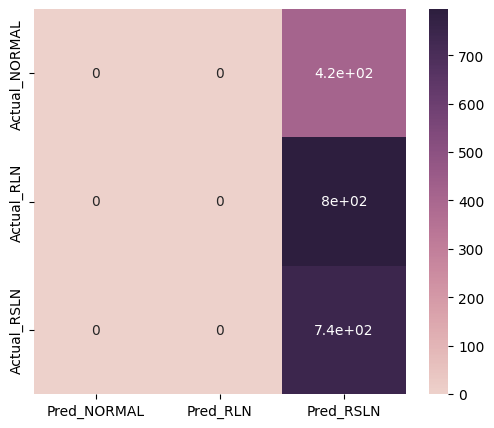

In [ ]:
_ = yasai.confusion_matrix(test_data, trained_resnet34_model, CLASSES)

/home/yasaisen/.local/lib/python3.8/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


accuracy = 0.3333333333333333
avg_precision = 0.11111111111109877
avg_recall = 0.33333333333322224


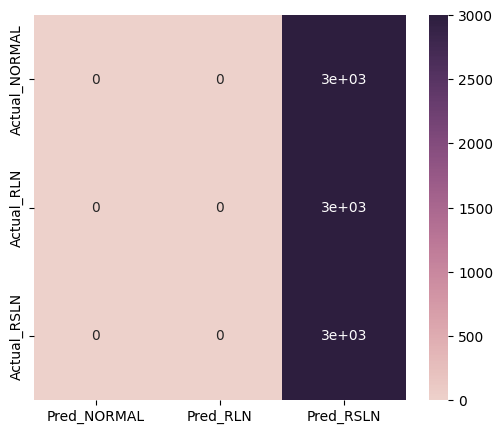

In [ ]:
_ = yasai.confusion_matrix(train_data, trained_resnet34_model, CLASSES)

In [ ]:
t = torch.randn((1, 3, 224, 224)).to(device)
print(t.shape)
get = trained_resnet34_model(t)
print(get)

torch.Size([1, 3, 224, 224])
tensor([[0.1657, 0.2702, 0.5641]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
